In [1]:
from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.kernels import get_f_Kkappa, get_f_KI, get_f_KILo, apply_window

In [2]:
# CCAT-Prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 #deg^2

chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

Pei = 5.7e4 #Jy / sr CCAT-prime

In [5]:
n_bins = 100
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [6]:
I_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_'
I_kappa_fname +='zmin_%.5f_zmax_%.5f_quad_next_%d.npy'%(zmin, 
                                                        zmax, 
                                                        1000)

I_kappa_unbinned = np.load(I_kappa_fname)

I_kappa = np.zeros((len(ells), n_bins))
external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 1000)
for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            I_kappa[:,i] = (np.sum(I_kappa_unbinned[:,idx1[0]:idx1[-1]+1,], 
                                 axis=(1)) / len(idx1))
            
vb = np.max(np.abs(I_kappa))

In [8]:
import matplotlib.pyplot as plt

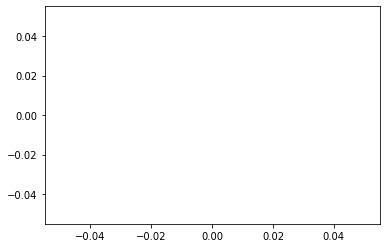

In [9]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": "11",
    "font.family" : "11"
})

In [10]:
log_ymin = np.log10(ells[0])
log_ymax = np.log10(ells[-1])


In [11]:
plot_Lambdas = np.arange(25)[12::6]


In [12]:
from matplotlib import colors
lin_factor = 1e1
linthresh = vb/lin_factor
norm = colors.SymLogNorm(linthresh=linthresh, 
                         linscale = np.log10(lin_factor),
                         vmin=-vb, 
                         vmax=vb, 
                         base=10)

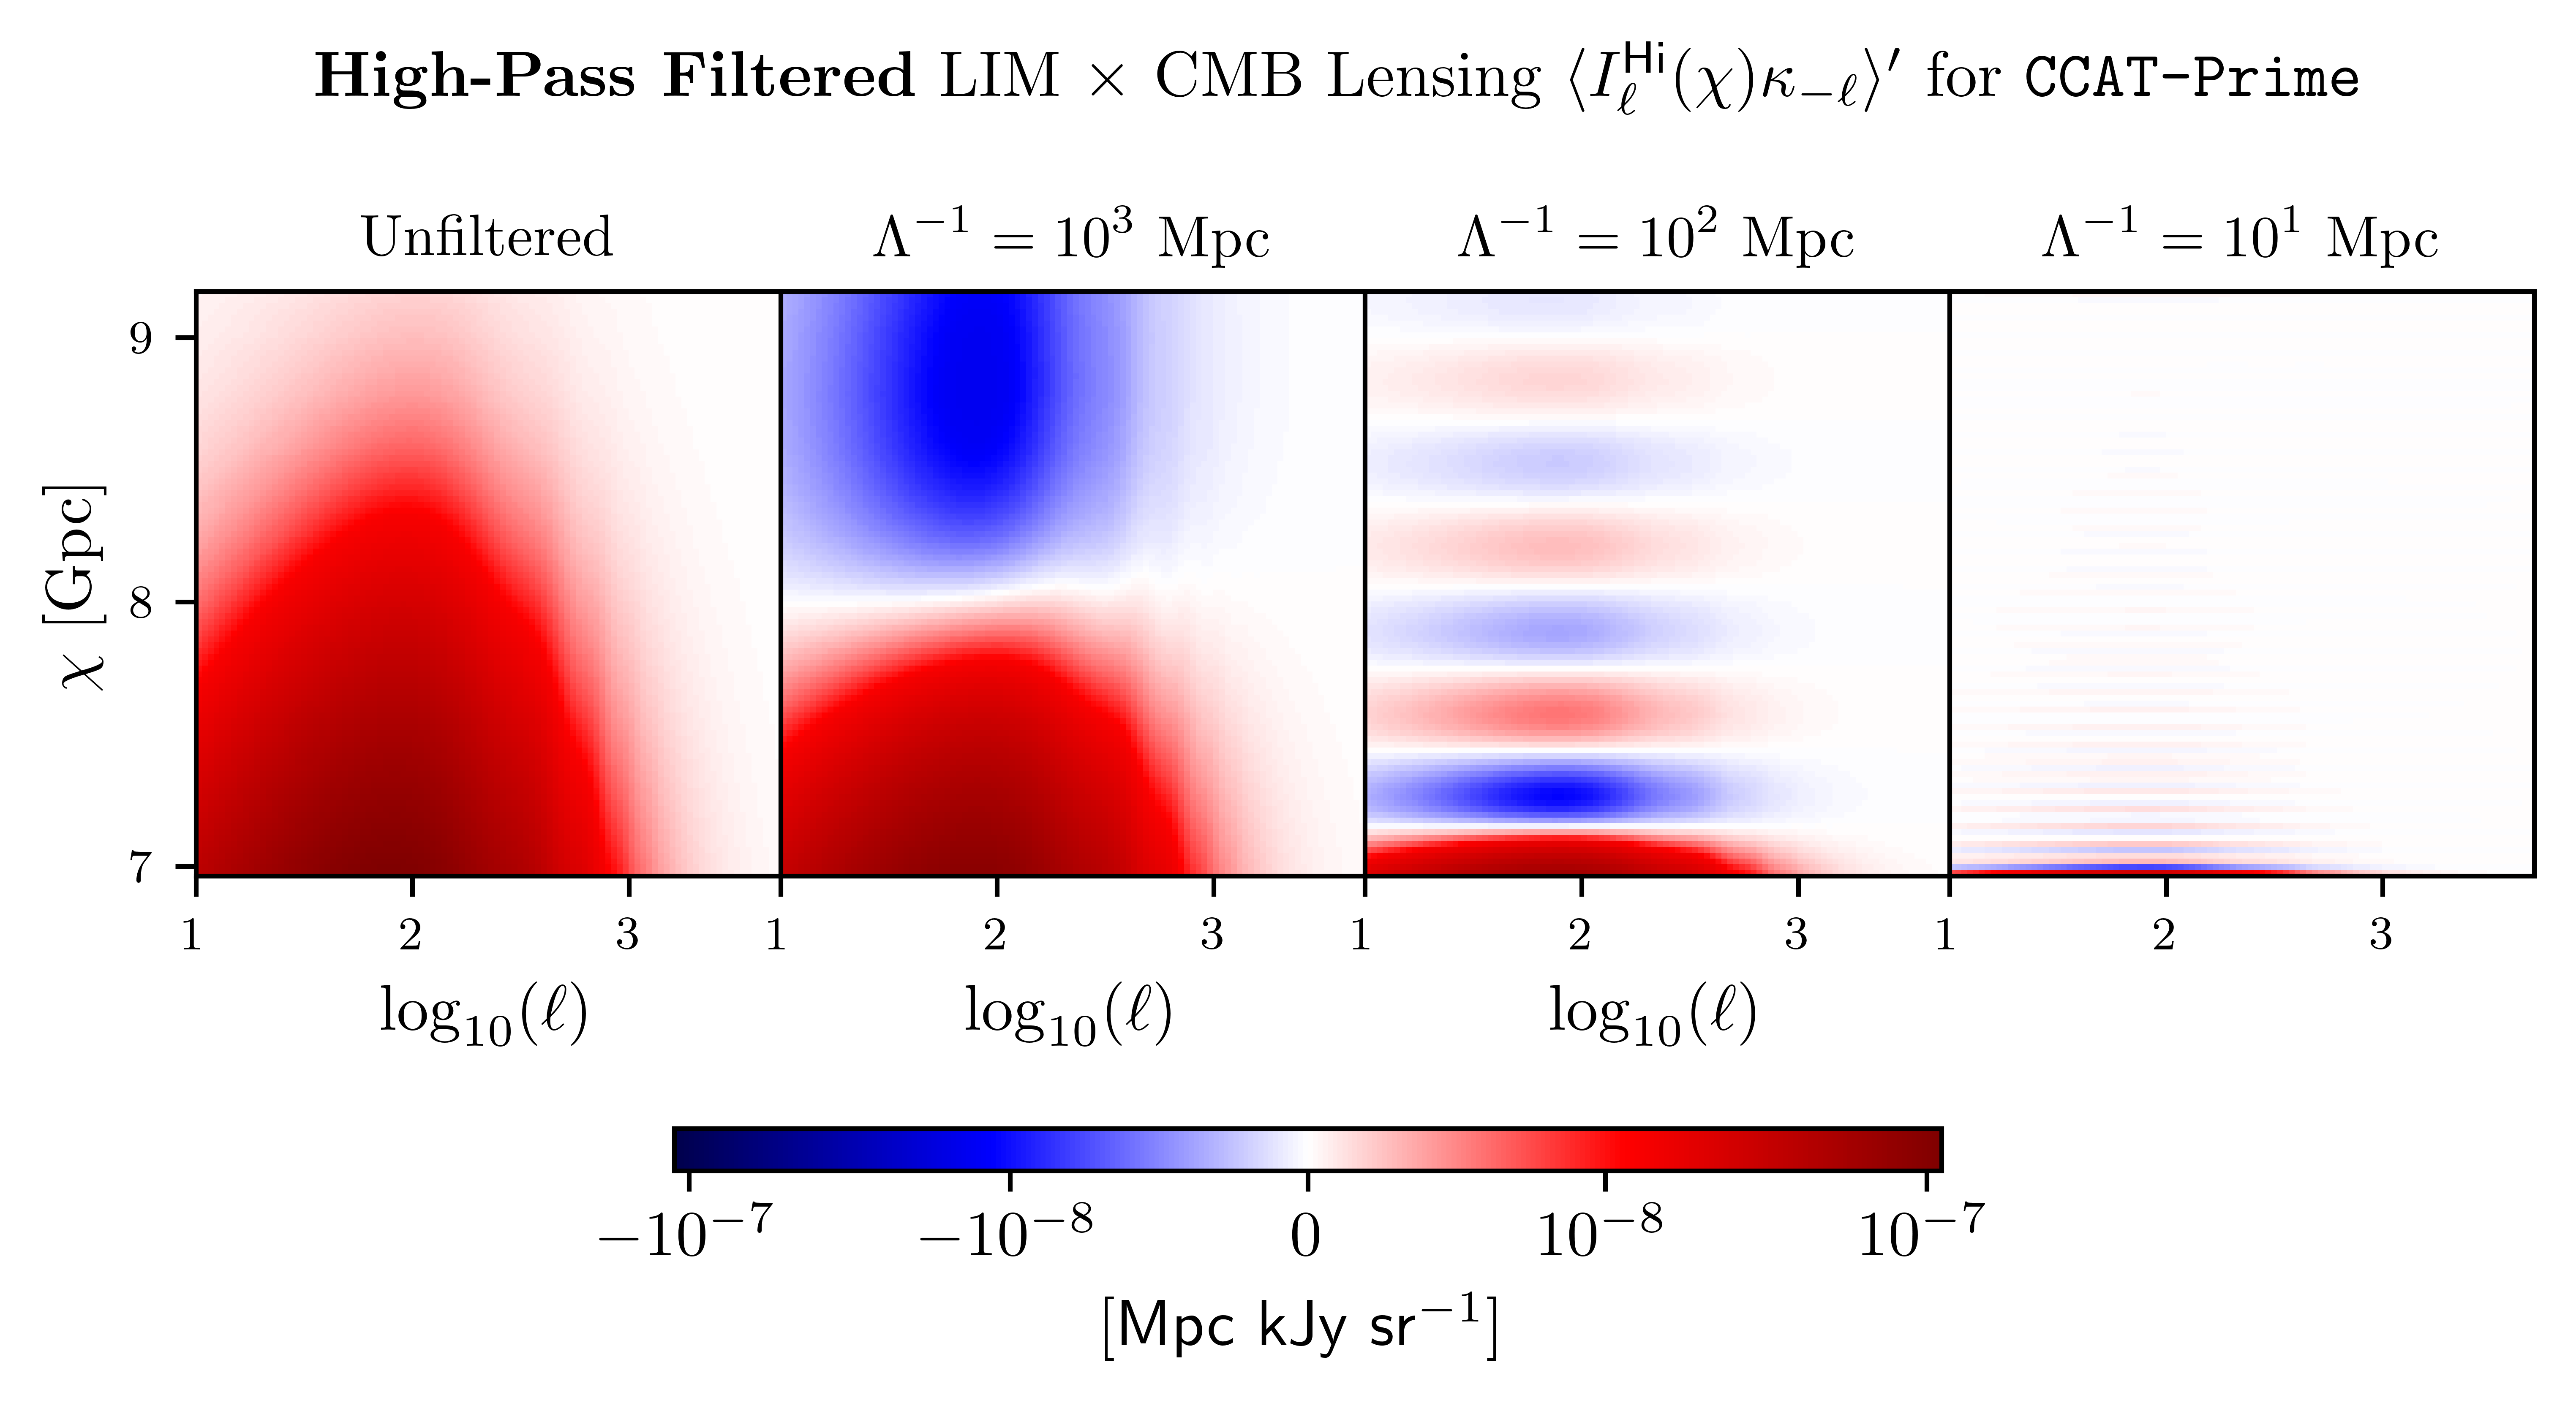

In [29]:
# fig, axs = plt.subplots(nrows = 3,
#                         ncols = 2, figsize = (6, 8), sharex=True,
#                         sharey=True, facecolor = 'w', dpi = 300)


fig, axs = plt.subplots(nrows=1, ncols=1+len(plot_Lambdas),figsize = (6, 2), facecolor = 'w', dpi = 1000)

plt.tight_layout(pad = 0.0)
plt.subplots_adjust(wspace =0)

axs = axs.flatten()


im = axs[0].imshow(I_kappa.T, 
               origin='lower',
              cmap = 'seismic',
                   norm = norm,
              aspect = (log_ymin - log_ymax)/(chimin-chimax) * 1000,
              extent=[log_ymin, log_ymax, chimin/1000, chimax/1000, ])

axs[0].set_title(r'Unfiltered',fontsize=10)
    
def plot(ax, data, vminmax, Lambda):
    im = ax.imshow(data.T, 
               origin='lower',
              cmap = 'seismic',
                   norm = norm,
              aspect = (log_ymin - log_ymax)/(chimin-chimax) * 1000,
              extent=[log_ymin, log_ymax, chimin/1000, chimax/1000, ])

    ax.set_title(r'$$\Lambda^{-1} = 10^{%d}\ {\rm Mpc}$$'%(-np.log10(Lambda)),fontsize=10)
    return im


ax_idx = 1
for Lambda_idx in plot_Lambdas:
    Lambda = Lambdas[Lambda_idx]

    ILo_kappa = np.zeros((100, n_bins))

    for curr_bin in range(n_bins):
        oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_'
        oup_fname+= 'zmin_%.5f_zmax_%.5f_idx_%d_dblquad_n_bins_%d_curr_%d.npy'%(zmin, zmax, 
                                                                                Lambda_idx, n_bins, 
                                                                                curr_bin)
        ILo_kappa[:,curr_bin] = np.load(oup_fname)

    IHi_kappa = I_kappa - ILo_kappa
    

    im = plot(axs[ax_idx], IHi_kappa.astype(np.float64), vb, Lambda=Lambda)
    ax_idx+=1
    
# _y = .125
cbar_ax = fig.add_axes([.25, -0.15, 0.5, 0.05])  # [left, bottom, width, height]


cbar = fig.colorbar(im, cax=cbar_ax,
                   orientation='horizontal',
                   label=r'[\textsf{Mpc kJy sr}${}^{-1}$]')


plt_left = plt.rcParams['figure.subplot.left']
plt_right = plt.rcParams['figure.subplot.right']
plt_cntr = (plt_left + plt_right) / 2

axs[0].set_ylabel(r'$\chi$ [{\rm Gpc}]')
# axs[2].set_xlabel(r'$\log_{10}(\ell)$')
# fig.text(plt_cntr, 0.05, r'$\log_{10}(\ell)$',
#          ha='center', 
#          va='top', 
#         fontsize=11)
for i in range(len(plot_Lambdas)):
    axs[i].set_xlabel(r'$\log_{10}(\ell)$')
    
axs[0].tick_params(axis='y', labelsize=8)
axs[0].set_yticks([7,8,9])
for i in range(len(axs)):
    axs[i].tick_params(axis='x', labelsize=8)
    if(i > 0):
        axs[i].set_yticks([])

fig.text(plt_cntr, 1.1, r"\textbf{High-Pass Filtered} LIM $\times$ CMB Lensing $\langle I_{ \ell}^{\sf Hi}(\chi) \kappa_{- \ell}\rangle'$ for \texttt{CCAT-Prime}",
         ha='center', 
         va='bottom', 
        fontsize=11)

plt.savefig('figures/002.012.CCAT-prime-viz.pdf', bbox_inches='tight')